<img src="../images/full-jtech-d-15-0020_1-f4.jpg" width=700 alt="QVP plot"></img>

Courtesy: Rizhkov, et al. (2014)

# Quasy-Vertical Profile 

---

In [1]:
import os
import gzip
import tempfile
import xarray as xr
import cmweather
import numpy as np
import xradar
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.xarray
import fsspec
from dask.distributed import Client, LocalCluster

In [2]:
cluster = LocalCluster(
    dashboard_address="127.0.0.1:8785",
)
client = Client(cluster)

## ARCO - FAIR workflow

In [3]:
path = "../zarr/KVNX_QVP.zarr"

In [4]:
dtree = xr.open_datatree(
    path,
    engine="zarr",
    consolidated=True,
    chunks={},
)

In [5]:
list(dtree.children)

['VCP-12']

In [6]:
list(dtree["VCP-12"].children)

['georeferencing_correction',
 'radar_calibration',
 'radar_parameters',
 'sweep_0',
 'sweep_1',
 'sweep_10',
 'sweep_11',
 'sweep_12',
 'sweep_13',
 'sweep_14',
 'sweep_15',
 'sweep_16',
 'sweep_2',
 'sweep_3',
 'sweep_4',
 'sweep_5',
 'sweep_6',
 'sweep_7',
 'sweep_8',
 'sweep_9']

In [7]:
ds_qvp = dtree["/VCP-12/sweep_16"].ds.sel(vcp_time=slice("2011-05-20 10:00","2011-05-20 12:00"))

In [8]:
def compute_qvp(ds: xr.Dataset, var="DBZH")-> xr.DataArray:
    """
    Computes a Quasi-Vertical Profile (QVP) from a radar time-series dataset.
    
    This function averages the specified variable over the azimuthal dimension
    to produce a QVP. If the variable is in dBZ (a logarithmic scale), it converts
    the values to linear units before averaging and then converts the result 
    back to dBZ.
    """
    units: str = ds[var].attrs['units']
    if units.startswith("dB"):
        qvp = 10 ** (ds[var] / 10)
        qvp = qvp.mean("azimuth", skipna=True)
        qvp = 10 * np.log10(qvp)
    else:
        qvp = ds[var]
        qvp = qvp.mean("azimuth", skipna=True)

    # computing heigth dimension
    qvp = qvp.assign_coords({"range":(qvp.range.values * 
                                 np.sin(
                                     ds.sweep_fixed_angle.mean(skipna=True).values *  
                                        np.pi / 180.)) /1000})

    qvp = qvp.rename(f"qvp_{var}")
    qvp = qvp.rename({"range": "height"})
    return qvp

In [9]:
%%time
ds_qvp = dtree["/VCP-12/sweep_16"].ds.sel(vcp_time=slice("2011-05-20 09:45","2011-05-20 12:15"))

CPU times: user 823 μs, sys: 902 μs, total: 1.73 ms
Wall time: 1.73 ms


In [10]:
%%time
qvp_ref = compute_qvp(ds_qvp, var="DBZH").compute()
qvp_zdr = compute_qvp(ds_qvp, var="ZDR").compute()
qvp_rhohv = compute_qvp(ds_qvp, var="RHOHV").compute()
qvp_phidp = compute_qvp(ds_qvp, var="PHIDP").compute()

CPU times: user 955 ms, sys: 53.1 ms, total: 1.01 s
Wall time: 1.61 s


CPU times: user 710 ms, sys: 36.9 ms, total: 747 ms
Wall time: 750 ms


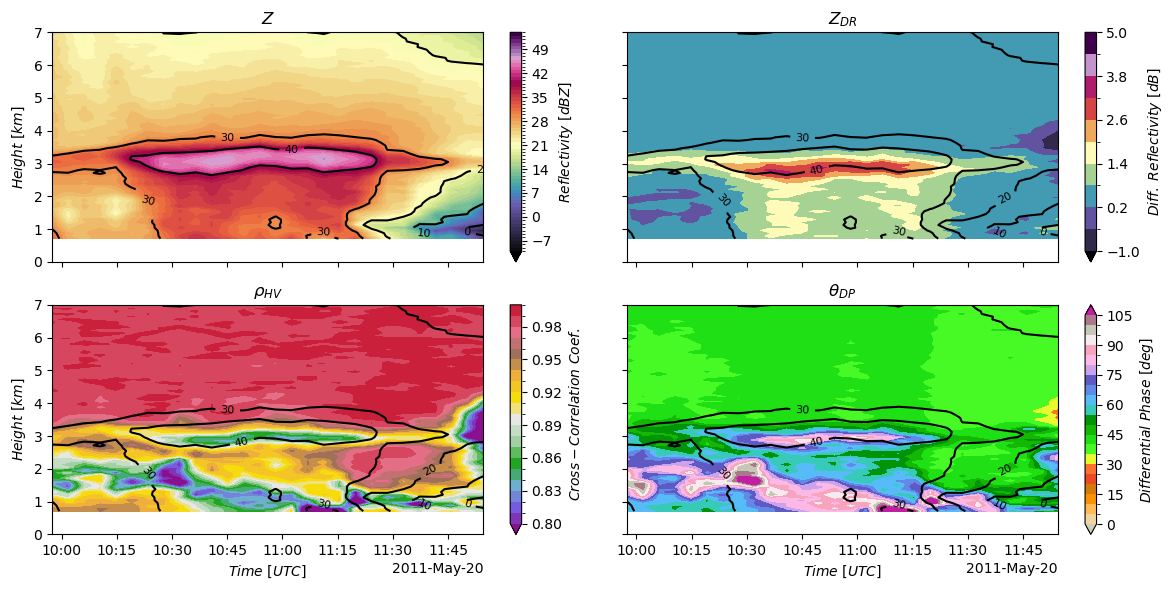

In [11]:
%%time
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharey=True, sharex=True)

## Reflectivity plot
cf = qvp_ref.plot.contourf(
    x="vcp_time",
    y="height",
    cmap="ChaseSpectral",
    levels=np.arange(-10, 55, 1),
    ax=axs[0][0],
    add_colorbar=False,
)
contour_lines = qvp_ref.plot.contour(
    x="vcp_time",
    y="height",
    colors="k",  # Black contour lines
    levels=np.arange(-10, 50, 10),  # Contour lines every 10 units
    ax=axs[0][0],
)
axs[0][0].clabel(contour_lines, fmt='%d', inline=True, fontsize=8)

axs[0][0].set_title(r"$Z$")
axs[0][0].set_xlabel("")
axs[0][0].set_ylabel(r"$Height \ [km]$")
axs[0][0].set_ylim(0,7)

cbar = plt.colorbar(cf, ax=axs[0][0], 
                    label=r"$Reflectivity \ [dBZ]$", 
                   )
## ZDR plot
cf1 = qvp_zdr.plot.contourf(
    x="vcp_time",
    y="height",
    cmap="ChaseSpectral",
    ax=axs[0][1],
    levels=np.linspace(-1, 5, 11),
    add_colorbar=False,
)

contour_lines = qvp_ref.plot.contour(
    x="vcp_time",
    y="height",
    colors="k",  # Black contour lines
    levels=np.arange(-10, 50, 10),  # Contour lines every 10 units
    ax=axs[0][1],
)
axs[0][1].clabel(contour_lines, fmt='%d', inline=True, fontsize=8) 

axs[0][1].set_title(r"$Z_{DR}$")
axs[0][1].set_xlabel("")
axs[0][1].set_ylabel(r"")

cbar = plt.colorbar(cf1, ax=axs[0][1], 
                    label=r"$Diff. \ Reflectivity \ [dB]$", 
                   )

### RHOHV plot
cf2 = qvp_rhohv.plot.contourf(
    x="vcp_time",
    y="height",
    cmap="Carbone11",
    ax=axs[1][0],
    levels=np.arange(0.8, 1.01, 0.01),
    add_colorbar=False,
)

contour_lines = qvp_ref.plot.contour(
    x="vcp_time",
    y="height",
    colors="k",  # Black contour lines
    levels=np.arange(-10, 50, 10),  # Contour lines every 10 units
    ax=axs[1][0],
)
axs[1][0].clabel(contour_lines, fmt='%d', inline=True, fontsize=8)

axs[1][0].set_title(r"$\rho _{HV}$")
axs[1][0].set_ylabel(r"$Height \ [km]$")
axs[1][0].set_xlabel(r"$Time \ [UTC]$")

cbar = plt.colorbar(cf2, ax=axs[1][0], 
                    label=r"$Cross-Correlation \ Coef.$", 
                   )

### PHIDP
cf3 = qvp_phidp.plot.contourf(
    x="vcp_time",
    y="height",
    cmap="PD17",
    ax=axs[1][1],
    levels=np.arange(0, 110, 5),
    add_colorbar=False,

)

contour_lines = qvp_ref.plot.contour(
    x="vcp_time",
    y="height",
    colors="k",  # Black contour lines
    levels=np.arange(-10, 50, 10),  # Contour lines every 10 units
    ax=axs[1][1],
)
axs[1][1].clabel(contour_lines, fmt='%d', inline=True, fontsize=8)

axs[1][1].set_title(r"$\theta _{DP}$")
axs[1][1].set_xlabel(r"$Time \ [UTC]$")
axs[1][1].set_ylabel(r"")

cbar = plt.colorbar(cf3, ax=axs[1][1], 
                    label=r"$Differential \ Phase \ [deg]$", 
                   )

fig.tight_layout()


## Traditional science workflow

### Data download

In [12]:
def nexrad_donwload(file):
    local_file = fsspec.open_local(
        f"simplecache::s3://{file}",
        s3={"anon": True},
        filecache={"cache_storage": "."},
    )
    with gzip.open(local_file, "rb") as gz:
        # Step 2: Write the decompressed content to a temporary file
        with tempfile.NamedTemporaryFile(delete=False) as temp_file:
            temp_file.write(gz.read())
            temp_file_path = temp_file.name

        # Step 3: Use xradar to open the temporary file
    try:
        data_tree = xradar.io.open_nexradlevel2_datatree(temp_file_path)        
    finally:
        # Step 4: Clean up the temporary files
        os.remove(local_file)
        os.remove(temp_file_path)
    return data_tree

### QVP dataset creation

In [13]:
radar = "KVNX"
append_dim = "vcp_time"
engine = "nexradlevel2"
zarr_format = 2
zarr_store = f"../zarr/{radar}_QVP.zarr"
query = f"2011/05/20/{radar}/{radar}"
str_bucket = "s3://noaa-nexrad-level2/"

fs = fsspec.filesystem("s3", anon=True)
radar_files = [f"s3://{i}" for i in sorted(fs.glob(f"{str_bucket}{query}*"))]

# only interested in the following files to recreate the VCP from Ryzhkov et al., (2014)
radar_files = radar_files[135:170]

#### Serial approach

In [14]:
%%time
ls_dataset = []
ls_time = []
for radar_file in radar_files:
    dtree = nexrad_donwload(radar_file)
    ls_time.append(pd.to_datetime(dtree.time_coverage_start.item()))
    ls_dataset.append(dtree["sweep_16"].to_dataset())
ds_trad_qvp = xr.concat(ls_dataset, dim="vcp_time")
ls_time = [ts.tz_convert(None) if ts.tzinfo else ts for ts in ls_time]
ds_trad_qvp = ds_trad_qvp.assign_coords(vcp_time=ls_time)

CPU times: user 4min 47s, sys: 59.9 s, total: 5min 47s
Wall time: 5min 38s


#### Parallel approach using dask bag

In [15]:
import dask.bag as db

def data_extraction(radar_file):
    dtree = nexrad_donwload(radar_file)
    time_start = pd.to_datetime(dtree.time_coverage_start.item())
    dataset = dtree["sweep_16"].to_dataset().load()
    return time_start, dataset

In [16]:
%%time
bag = db.from_sequence(radar_files).map(data_extraction)
ls_time, ls_dataset = zip(*bag.persist())
ds_trad_qvp = xr.concat(ls_dataset, dim="vcp_time")
ls_time = [ts.tz_convert(None) if ts.tzinfo else ts for ts in ls_time]
ds_trad_qvp = ds_trad_qvp.assign_coords(vcp_time=ls_time)

CPU times: user 15.7 s, sys: 2.5 s, total: 18.2 s
Wall time: 2min 38s


## QVP calculations

In [17]:
%%time
qvp_trad_ref = compute_qvp(ds_trad_qvp, var="DBZH")
qvp_trad_zdr = compute_qvp(ds_trad_qvp, var="ZDR")
qvp_trad_rhohv = compute_qvp(ds_trad_qvp, var="RHOHV")
qvp_trad_phidp = compute_qvp(ds_trad_qvp, var="PHIDP")

CPU times: user 1.19 s, sys: 182 ms, total: 1.38 s
Wall time: 1.28 s


CPU times: user 500 ms, sys: 18.5 ms, total: 518 ms
Wall time: 500 ms


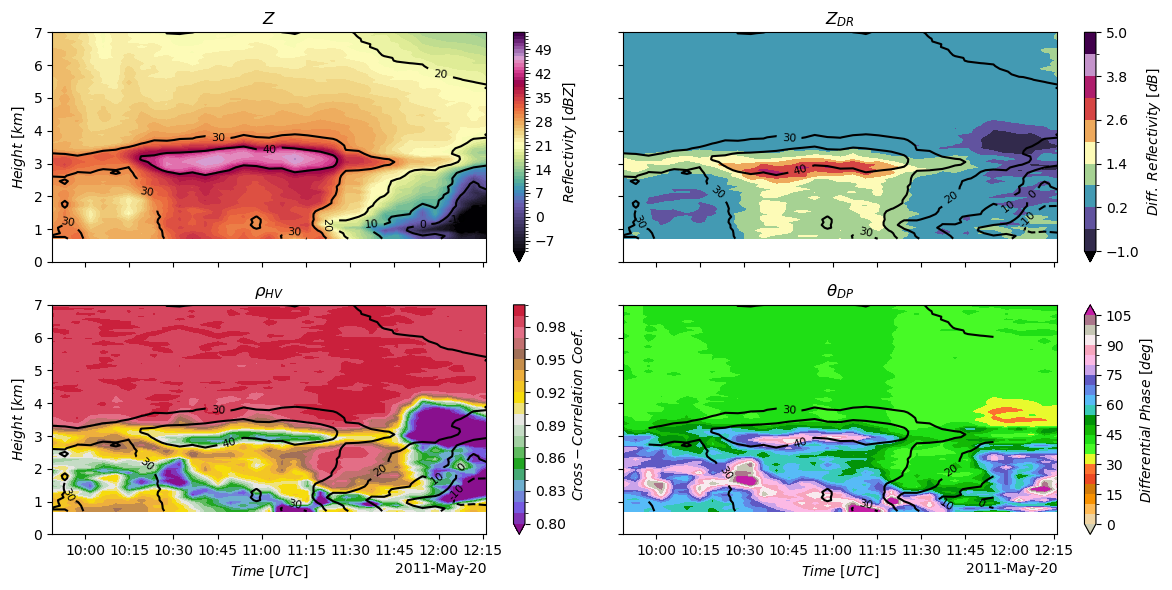

In [19]:
%%time
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharey=True, sharex=True)

## Reflectivity plot
cf = qvp_trad_ref.plot.contourf(
    x="vcp_time",
    y="height",
    cmap="ChaseSpectral",
    levels=np.arange(-10, 55, 1),
    ax=axs[0][0],
    add_colorbar=False,
)
contour_lines = qvp_trad_ref.plot.contour(
    x="vcp_time",
    y="height",
    colors="k",  # Black contour lines
    levels=np.arange(-10, 50, 10),  # Contour lines every 10 units
    ax=axs[0][0],
)
axs[0][0].clabel(contour_lines, fmt='%d', inline=True, fontsize=8)

axs[0][0].set_title(r"$Z$")
axs[0][0].set_xlabel("")
axs[0][0].set_ylabel(r"$Height \ [km]$")
axs[0][0].set_ylim(0,7)

cbar = plt.colorbar(cf, ax=axs[0][0], 
                    label=r"$Reflectivity \ [dBZ]$", 
                   )
## ZDR plot
cf1 = qvp_trad_zdr.plot.contourf(
    x="vcp_time",
    y="height",
    cmap="ChaseSpectral",
    ax=axs[0][1],
    levels=np.linspace(-1, 5, 11),
    add_colorbar=False,
)

contour_lines = qvp_trad_ref.plot.contour(
    x="vcp_time",
    y="height",
    colors="k",  # Black contour lines
    levels=np.arange(-10, 50, 10),  # Contour lines every 10 units
    ax=axs[0][1],
)
axs[0][1].clabel(contour_lines, fmt='%d', inline=True, fontsize=8) 

axs[0][1].set_title(r"$Z_{DR}$")
axs[0][1].set_xlabel("")
axs[0][1].set_ylabel(r"")

cbar = plt.colorbar(cf1, ax=axs[0][1], 
                    label=r"$Diff. \ Reflectivity \ [dB]$", 
                   )

### RHOHV plot
cf2 = qvp_trad_rhohv.plot.contourf(
    x="vcp_time",
    y="height",
    cmap="Carbone11",
    ax=axs[1][0],
    levels=np.arange(0.8, 1.01, 0.01),
    add_colorbar=False,
)

contour_lines = qvp_trad_ref.plot.contour(
    x="vcp_time",
    y="height",
    colors="k",  # Black contour lines
    levels=np.arange(-10, 50, 10),  # Contour lines every 10 units
    ax=axs[1][0],
)
axs[1][0].clabel(contour_lines, fmt='%d', inline=True, fontsize=8)

axs[1][0].set_title(r"$\rho _{HV}$")
axs[1][0].set_ylabel(r"$Height \ [km]$")
axs[1][0].set_xlabel(r"$Time \ [UTC]$")

cbar = plt.colorbar(cf2, ax=axs[1][0], 
                    label=r"$Cross-Correlation \ Coef.$", 
                   )

### PHIDP
cf3 = qvp_trad_phidp.plot.contourf(
    x="vcp_time",
    y="height",
    cmap="PD17",
    ax=axs[1][1],
    levels=np.arange(0, 110, 5),
    add_colorbar=False,

)

contour_lines = qvp_ref.plot.contour(
    x="vcp_time",
    y="height",
    colors="k",  # Black contour lines
    levels=np.arange(-10, 50, 10),  # Contour lines every 10 units
    ax=axs[1][1],
)
axs[1][1].clabel(contour_lines, fmt='%d', inline=True, fontsize=8)

axs[1][1].set_title(r"$\theta _{DP}$")
axs[1][1].set_xlabel(r"$Time \ [UTC]$")
axs[1][1].set_ylabel(r"")

cbar = plt.colorbar(cf3, ax=axs[1][1], 
                    label=r"$Differential \ Phase \ [deg]$", 
                   )

fig.tight_layout()


---

## Conclusions

The performance comparison reveals a dramatic improvement in processing efficiency when using the ARCO FAIR data workflow:

Time Efficiency:

- The ARCO FAIR workflow completes the task in 1.61 seconds, significantly outperforming the traditional science workflows.
- The traditional science workflow takes  5 minutes 38 seconds (338 seconds) in serial mode and 2 minutes 38 seconds (158 seconds), demonstrating a clear bottleneck in both cases.

Scalability:

- Even when leveraging parallelism, the traditional science workflow is considerably slower, highlighting the inherent advantages of the ARCO FAIR approach.

Practical Implications:

- The ARCO FAIR workflow provides a **~210x** speedup over serial processing and a **~98x** speedup over parallel processing, offering substantial time savings and better resource utilization.

Hardware Configuration:

- These results were achieved on a standard hardware configuration, including an **Intel Core i7 processor**, **32 GB DDR4 RAM**, and an **NVME solid-state disk drive** laptop, underscoring the ARCO FAIR workflow's efficiency on widely accessible systems.

This significant improvement underscores the transformative value of modern FAIR-compliant methodologies in optimizing data accessibility, reusability, and processing efficiency, making them indispensable for contemporary scientific workflows.

## References

* Ryzhkov, A., P. Zhang, H. Reeves, M. Kumjian, T. Tschallener, S. Trömel, and C. Simmer, 2016: Quasi-Vertical Profiles—A New Way to Look at Polarimetric Radar Data. J. Atmos. Oceanic Technol., 33, 551–562, https://doi.org/10.1175/JTECH-D-15-0020.1.